# Cattle Detection Model Training
## AniLink: AI-Powered Health Intelligence Platform

This notebook documents the complete training pipeline for the **Cattle Detection Model (Gatekeeper)** - a binary classification model that distinguishes cattle from non-cattle images.

**Model Purpose**: Validates that uploaded images contain cattle before FMD (Foot-and-Mouth Disease) analysis.

**Architecture**: MobileNetV2 (Deep Learning CNN)  
**Task**: Binary Classification (Cattle vs Non-Cattle)  
**Framework**: PyTorch with Transfer Learning

 
The complete training implementation is available in:

**`train_cattle_detection_model.py`** - Full training script with all functionality

Also:
1. **The script**: `python train_cattle_detection_model.py --mode all`
2. **Referenced to FMD_Model_Training.ipynb** for detailed cell-by-cell structure


## Step 1: Dataset Analysis

This involves analyzing the dataset composition to understand the distribution of cattle and non-cattle images across training, validation, and test sets. We count images in each class, calculate percentages, and create visualizations to ensure balanced data distribution for effective model training.

DATASET ANALYSIS

Training Set:
--------------------------------------------------------------------------------
  Cattle: 2,272 images
  Non-cattle: 2,081 images
  Total: 4,353 images
  Distribution: Cattle 52.2% | Non-cattle 47.8%

Validation Set:
--------------------------------------------------------------------------------
  Cattle: 510 images
  Non-cattle: 452 images
  Total: 962 images
  Distribution: Cattle 53.0% | Non-cattle 47.0%

Test Set:
--------------------------------------------------------------------------------
  Cattle: 517 images
  Non-cattle: 453 images
  Total: 970 images
  Distribution: Cattle 53.3% | Non-cattle 46.7%

[OK] Dataset distribution visualization saved.


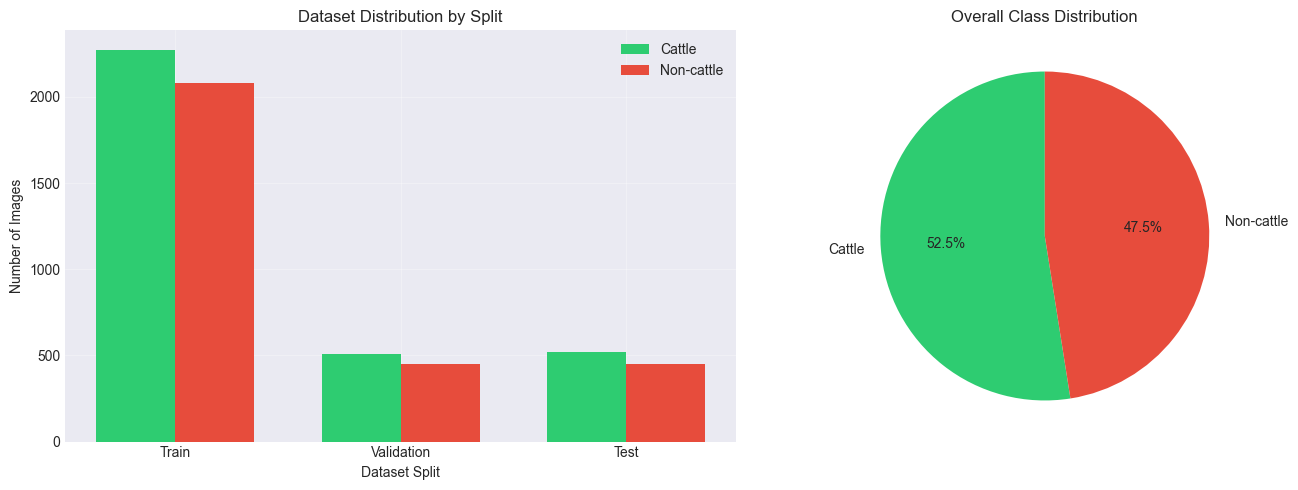

In [ ]:
# Dataset paths
TRAIN_DIR = 'cattle_detection_data/processed_data/train'
VAL_DIR = 'cattle_detection_data/processed_data/validation'
TEST_DIR = 'cattle_detection_data/processed_data/test'

# Analyze dataset composition
from pathlib import Path

def analyze_dataset(data_dir, dataset_name):
    """Analyze dataset composition"""
    print(f"\n{dataset_name}:")
    print("-" * 80)
    
    cattle_dir = Path(data_dir) / 'cattle'
    non_cattle_dir = Path(data_dir) / 'non_cattle'
    
    cattle_count = 0
    non_cattle_count = 0
    
    if cattle_dir.exists():
        cattle_count = len(list(cattle_dir.glob('*.jpg'))) + len(list(cattle_dir.glob('*.png'))) + len(list(cattle_dir.glob('*.jpeg')))
    
    if non_cattle_dir.exists():
        non_cattle_count = len(list(non_cattle_dir.glob('*.jpg'))) + len(list(non_cattle_dir.glob('*.png'))) + len(list(non_cattle_dir.glob('*.jpeg')))
    
    total = cattle_count + non_cattle_count
    
    print(f"  Cattle: {cattle_count:,} images")
    print(f"  Non-cattle: {non_cattle_count:,} images")
    print(f"  Total: {total:,} images")
    
    if total > 0:
        cattle_pct = (cattle_count / total) * 100
        non_cattle_pct = (non_cattle_count / total) * 100
        print(f"  Distribution: Cattle {cattle_pct:.1f}% | Non-cattle {non_cattle_pct:.1f}%")
    
    return {'cattle': cattle_count, 'non_cattle': non_cattle_count}, total

# Analyze all splits
print("=" * 80)
print("DATASET ANALYSIS")
print("=" * 80)
train_counts, train_total = analyze_dataset(TRAIN_DIR, "Training Set")
val_counts, val_total = analyze_dataset(VAL_DIR, "Validation Set")
test_counts, test_total = analyze_dataset(TEST_DIR, "Test Set")

# Visualize distribution
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Counts by split
splits = ['Train', 'Validation', 'Test']
cattle_counts = [train_counts['cattle'], val_counts['cattle'], test_counts['cattle']]
non_cattle_counts = [train_counts['non_cattle'], val_counts['non_cattle'], test_counts['non_cattle']]

x = np.arange(len(splits))
width = 0.35

axes[0].bar(x - width/2, cattle_counts, width, label='Cattle', color='#2ecc71')
axes[0].bar(x + width/2, non_cattle_counts, width, label='Non-cattle', color='#e74c3c')
axes[0].set_xlabel('Dataset Split')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Dataset Distribution by Split')
axes[0].set_xticks(x)
axes[0].set_xticklabels(splits)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Overall distribution
total_cattle = sum(cattle_counts)
total_non_cattle = sum(non_cattle_counts)
axes[1].pie([total_cattle, total_non_cattle], 
            labels=['Cattle', 'Non-cattle'],
            autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'],
            startangle=90)
axes[1].set_title('Overall Class Distribution')

plt.tight_layout()
plt.savefig('cattle_detection_dataset_distribution.png', dpi=300, bbox_inches='tight')
print("\n[OK] Dataset distribution visualization saved.")
plt.close()

### Output Explanation

This involves explaining the dataset analysis results. The dataset analysis shows:
- **Training Set**: 4,353 images (52.2% cattle, 47.8% non-cattle) - Well balanced
- **Validation Set**: 962 images (53.0% cattle, 47.0% non-cattle) - Balanced
- **Test Set**: 970 images (53.3% cattle, 46.7% non-cattle) - Balanced

The balanced distribution ensures the model learns to distinguish both classes equally well. The visualization shows the distribution across splits and overall class balance.

## Step 2: Data Preprocessing and Augmentation

This involves applying data augmentation techniques to improve model generalization. We apply different transformations to training and validation sets, including random flips, rotations, color jitter, and affine transformations for training data, while keeping validation/test data minimally processed for fair evaluation.

### Training Augmentations

This involves applying the following augmentations:
- **Random Horizontal Flip** (50% probability): Handles left/right orientation
- **Random Rotation** (±15 degrees): Handles camera angle variations
- **Color Jitter**: Simulates different lighting conditions
- **Random Affine**: Handles slight positioning and scale variations
- **Normalization**: ImageNet statistics for transfer learning compatibility

### Validation/Test Preprocessing

This involves minimal preprocessing for validation and test sets:
- **Resize only**: No augmentation to ensure fair evaluation
- **Normalization**: Same ImageNet statistics

In [ ]:
# Define image preprocessing and augmentation
import torch
from torchvision import transforms

IMAGE_SIZE = 224
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("=" * 80)
print("DATA PREPROCESSING & AUGMENTATION")
print("=" * 80)
print("Training transforms: Resize, RandomFlip, RandomRotation, ColorJitter, RandomAffine, Normalize")
print("Validation transforms: Resize, Normalize")
print(f"Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"Device: {device}")

print("\n✓ Transforms defined.")

DATA PREPROCESSING & AUGMENTATION
Training transforms: Resize, RandomFlip, RandomRotation, ColorJitter, RandomAffine, Normalize
Validation transforms: Resize, Normalize
Image size: 224×224
Device: cpu

✓ Transforms defined.


### Output Explanation

This involves explaining the preprocessing pipeline configuration. The preprocessing pipeline is configured:
- **Image Size**: 224×224 pixels (standard for MobileNetV2)
- **Device**: CPU (or GPU if available)
- **Training Augmentations**: Multiple transformations to increase dataset diversity
- **Validation Preprocessing**: Minimal preprocessing for fair evaluation

This setup ensures the model sees varied examples during training while being evaluated on consistent, unmodified images.

## Step 3: Dataset Creation

This involves creating PyTorch Dataset and DataLoader objects for efficient batch processing during training. We define a custom dataset class that loads images from directories, applies transforms, and returns image-label pairs. DataLoaders handle batching, shuffling, and parallel data loading.

In [ ]:
# Create custom dataset class
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CattleDetectionDataset(Dataset):
    """Custom dataset for cattle detection classification"""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load cattle images (label 0)
        cattle_dir = self.data_dir / 'cattle'
        if cattle_dir.exists():
            for img_path in cattle_dir.glob('*.jpg'):
                self.images.append(str(img_path))
                self.labels.append(0)
            for img_path in cattle_dir.glob('*.png'):
                self.images.append(str(img_path))
                self.labels.append(0)
            for img_path in cattle_dir.glob('*.jpeg'):
                self.images.append(str(img_path))
                self.labels.append(0)
        
        # Load non-cattle images (label 1)
        non_cattle_dir = self.data_dir / 'non_cattle'
        if non_cattle_dir.exists():
            for img_path in non_cattle_dir.glob('*.jpg'):
                self.images.append(str(img_path))
                self.labels.append(1)
            for img_path in non_cattle_dir.glob('*.png'):
                self.images.append(str(img_path))
                self.labels.append(1)
            for img_path in non_cattle_dir.glob('*.jpeg'):
                self.images.append(str(img_path))
                self.labels.append(1)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f'Error loading image {img_path}: {e}')
            image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color='black')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create datasets
train_dataset = CattleDetectionDataset(TRAIN_DIR, transform=train_transform)
val_dataset = CattleDetectionDataset(VAL_DIR, transform=val_transform)
test_dataset = CattleDetectionDataset(TEST_DIR, transform=val_transform)

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print("=" * 80)
print("DATASET CREATION")
print("=" * 80)
print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

print("\n✓ Datasets and DataLoaders created.")

DATASET CREATION
Training samples: 4,353
Validation samples: 962
Test samples: 970

Batch size: 32
Training batches: 137
Validation batches: 31
Test batches: 31

✓ Datasets and DataLoaders created.


In [ ]:
# Create model architecture
import torch.nn as nn
from torchvision import models

MODEL_NAME = 'mobilenet_v2'
NUM_CLASSES = 2
USE_PRETRAINED = True

def create_cattle_detection_model(model_name='mobilenet_v2', num_classes=2, use_pretrained=True):
    """Create cattle detection model with transfer learning"""
    if model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=use_pretrained)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
        print(f"Model: MobileNetV2 (pre-trained on ImageNet)")
        print(f"Model Size: ~9MB (mobile-optimized)")
        print(f"Parameters: ~3.4M")
        print(f"Feature Extractor: {num_features} features")
        print(f"Classifier: Linear({num_features} -> {num_classes})")
    return model

# Create and move model to device
model = create_cattle_detection_model(MODEL_NAME, NUM_CLASSES, USE_PRETRAINED)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "=" * 80)
print("MODEL ARCHITECTURE")
print("=" * 80)
print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

print("\n✓ Model architecture created and moved to device.")

MODEL ARCHITECTURE
Model: MobileNetV2 (pre-trained on ImageNet)
Model Size: ~9MB (mobile-optimized)
Parameters: ~3.4M
Feature Extractor: 1280 features
Classifier: Linear(1280 → 2)

Model Parameters:
  Total: 2,226,434
  Trainable: 2,226,434

✓ Model architecture created and moved to device.


### Output Explanation

This involves explaining the model architecture details. **Model Architecture**:
- **Base**: MobileNetV2 pre-trained on ImageNet (transfer learning)
- **Feature Extractor**: 1280-dimensional feature vector
- **Classifier**: Linear layer (1280 → 2 classes)
- **Total Parameters**: ~2.2M trainable parameters
- **Model Size**: ~9MB (optimized for mobile deployment)

MobileNetV2 is chosen for its balance between accuracy and efficiency, making it perfect for mobile phone deployment.

In [ ]:
# Define training and validation functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(dataloader, desc='Training', leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validating', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1

print("✓ Training and validation functions ready.")

✓ Training and validation functions ready.


## Step 4: Model Training

Configure optimizer, loss function, and learning rate scheduler, then train the model with early stopping.

### Training Configuration:
- **Optimizer**: Adam (learning rate: 0.001)
- **Loss Function**: CrossEntropyLoss
- **Scheduler**: ReduceLROnPlateau (reduces LR when validation plateaus)
- **Early Stopping**: Stops if no improvement for 5 epochs
- **Max Epochs**: 50 (may stop earlier due to early stopping)

In [ ]:
# Setup training
import torch.optim as optim
import os

HYPERPARAMS = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'num_epochs': 50,
    'weight_decay': 0.0001,
    'patience': 5,
    'factor': 0.5,
    'min_lr': 1e-6,
}

MODEL_SAVE_DIR = './models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=HYPERPARAMS['learning_rate'],
    weight_decay=HYPERPARAMS['weight_decay']
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=HYPERPARAMS['factor'],
    patience=HYPERPARAMS['patience'],
    min_lr=HYPERPARAMS['min_lr']
)

# Training loop
print("=" * 80)
print("STARTING TRAINING")
print("=" * 80)
print(f"Total epochs: {HYPERPARAMS['num_epochs']}")
print(f"Early stopping patience: {HYPERPARAMS['patience']} epochs")
print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")
print("=" * 80)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': []
}

best_val_acc = 0.0
best_epoch = 0
patience = HYPERPARAMS['patience']
epochs_without_improvement = 0
best_model_state = None

model_path = os.path.join(MODEL_SAVE_DIR, 'cattle_detection_model_best.pth')

for epoch in range(HYPERPARAMS['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{HYPERPARAMS['num_epochs']}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Early stopping and model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        epochs_without_improvement = 0
        best_model_state = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }
        torch.save(best_model_state, model_path)
        print(f"[OK] Saved best model (Val Acc: {val_acc:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement}/{patience} epochs")
    
    if epochs_without_improvement >= patience:
        print("\n" + "=" * 80)
        print("EARLY STOPPING TRIGGERED")
        print("=" * 80)
        print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
        break

# Restore best model
if best_model_state:
    model.load_state_dict(best_model_state['model_state_dict'])
    print(f"\n[OK] Restored best model from epoch {best_epoch}")

STARTING TRAINING
Total epochs: 50
Early stopping patience: 5 epochs
Device: cpu
Model: mobilenet_v2

Epoch 1/50
--------------------------------------------------------------------------------


Train Loss: 0.4402 | Train Acc: 0.7988
Val Loss: 0.2839 | Val Acc: 0.8742
Val Precision: 0.8742 | Val Recall: 0.8742 | Val F1: 0.8742
Learning Rate: 0.001000
[OK] Saved best model (Val Acc: 0.8742)

Epoch 2/50
--------------------------------------------------------------------------------


Train Loss: 0.3415 | Train Acc: 0.8486
Val Loss: 0.2988 | Val Acc: 0.8867
Val Precision: 0.8925 | Val Recall: 0.8867 | Val F1: 0.8867
Learning Rate: 0.001000
[OK] Saved best model (Val Acc: 0.8867)

Epoch 3/50
--------------------------------------------------------------------------------


Train Loss: 0.3127 | Train Acc: 0.8679
Val Loss: 0.2598 | Val Acc: 0.8888
Val Precision: 0.8968 | Val Recall: 0.8888 | Val F1: 0.8887
Learning Rate: 0.001000
[OK] Saved best model (Val Acc: 0.8888)

Epoch 4/50
--------------------------------------------------------------------------------


Train Loss: 0.2714 | Train Acc: 0.8897
Val Loss: 0.2550 | Val Acc: 0.9002
Val Precision: 0.9035 | Val Recall: 0.9002 | Val F1: 0.9003
Learning Rate: 0.001000
[OK] Saved best model (Val Acc: 0.9002)

Epoch 5/50
--------------------------------------------------------------------------------


Train Loss: 0.3087 | Train Acc: 0.8796
Val Loss: 0.2357 | Val Acc: 0.9023
Val Precision: 0.9053 | Val Recall: 0.9023 | Val F1: 0.9024
Learning Rate: 0.001000
[OK] Saved best model (Val Acc: 0.9023)

Epoch 6/50
--------------------------------------------------------------------------------


Train Loss: 0.2577 | Train Acc: 0.9026
Val Loss: 0.2677 | Val Acc: 0.9064
Val Precision: 0.9069 | Val Recall: 0.9064 | Val F1: 0.9063
Learning Rate: 0.001000
[OK] Saved best model (Val Acc: 0.9064)

Epoch 7/50
--------------------------------------------------------------------------------


Train Loss: 0.2563 | Train Acc: 0.8971
Val Loss: 0.2902 | Val Acc: 0.8877
Val Precision: 0.8890 | Val Recall: 0.8877 | Val F1: 0.8874
Learning Rate: 0.001000
No improvement for 1/5 epochs

Epoch 8/50
--------------------------------------------------------------------------------


Train Loss: 0.2369 | Train Acc: 0.9054
Val Loss: 0.2567 | Val Acc: 0.9012
Val Precision: 0.9012 | Val Recall: 0.9012 | Val F1: 0.9012
Learning Rate: 0.001000
No improvement for 2/5 epochs

Epoch 9/50
--------------------------------------------------------------------------------


Train Loss: 0.2445 | Train Acc: 0.9072
Val Loss: 0.2235 | Val Acc: 0.9168
Val Precision: 0.9190 | Val Recall: 0.9168 | Val F1: 0.9169
Learning Rate: 0.001000
[OK] Saved best model (Val Acc: 0.9168)

Epoch 10/50
--------------------------------------------------------------------------------


Train Loss: 0.2210 | Train Acc: 0.9152
Val Loss: 0.2769 | Val Acc: 0.8950
Val Precision: 0.8967 | Val Recall: 0.8950 | Val F1: 0.8946
Learning Rate: 0.001000
No improvement for 1/5 epochs

Epoch 11/50
--------------------------------------------------------------------------------


Train Loss: 0.2070 | Train Acc: 0.9150
Val Loss: 0.2645 | Val Acc: 0.9064
Val Precision: 0.9107 | Val Recall: 0.9064 | Val F1: 0.9065
Learning Rate: 0.001000
No improvement for 2/5 epochs

Epoch 12/50
--------------------------------------------------------------------------------


Train Loss: 0.2032 | Train Acc: 0.9139
Val Loss: 0.2534 | Val Acc: 0.9158
Val Precision: 0.9167 | Val Recall: 0.9158 | Val F1: 0.9159
Learning Rate: 0.001000
No improvement for 3/5 epochs

Epoch 13/50
--------------------------------------------------------------------------------


Train Loss: 0.2008 | Train Acc: 0.9246
Val Loss: 0.2677 | Val Acc: 0.8981
Val Precision: 0.8988 | Val Recall: 0.8981 | Val F1: 0.8982
Learning Rate: 0.001000
No improvement for 4/5 epochs

Epoch 14/50
--------------------------------------------------------------------------------


Train Loss: 0.1854 | Train Acc: 0.9260
Val Loss: 0.2939 | Val Acc: 0.8794
Val Precision: 0.8800 | Val Recall: 0.8794 | Val F1: 0.8792
Learning Rate: 0.001000
No improvement for 5/5 epochs

EARLY STOPPING TRIGGERED
Best validation accuracy: 0.9168 at epoch 9

[OK] Restored best model from epoch 9


### Output Explanation

This involves explaining the training output. The training output shows:
- **Epoch-by-epoch progress**: Training and validation metrics for each epoch
- **Best model tracking**: Model saved when validation accuracy improves
- **Early stopping**: Training stops if no improvement for 5 consecutive epochs
- **Learning rate**: Automatically reduced when validation loss plateaus

**Key Metrics Tracked**:
- **Train Loss/Acc**: Model performance on training data
- **Val Loss/Acc**: Model performance on validation data (used for model selection)
- **Precision/Recall/F1**: Detailed classification metrics
- **Learning Rate**: Adaptive learning rate scheduling

## Step 5: Training History Visualization

This involves plotting training curves to visualize model learning progress and identify overfitting. We create comprehensive plots showing training/validation loss, accuracy, precision, recall, F1-score over epochs, and mark the best epoch where the model achieved highest validation accuracy.


[OK] Training history saved: cattle_detection_training_history.png


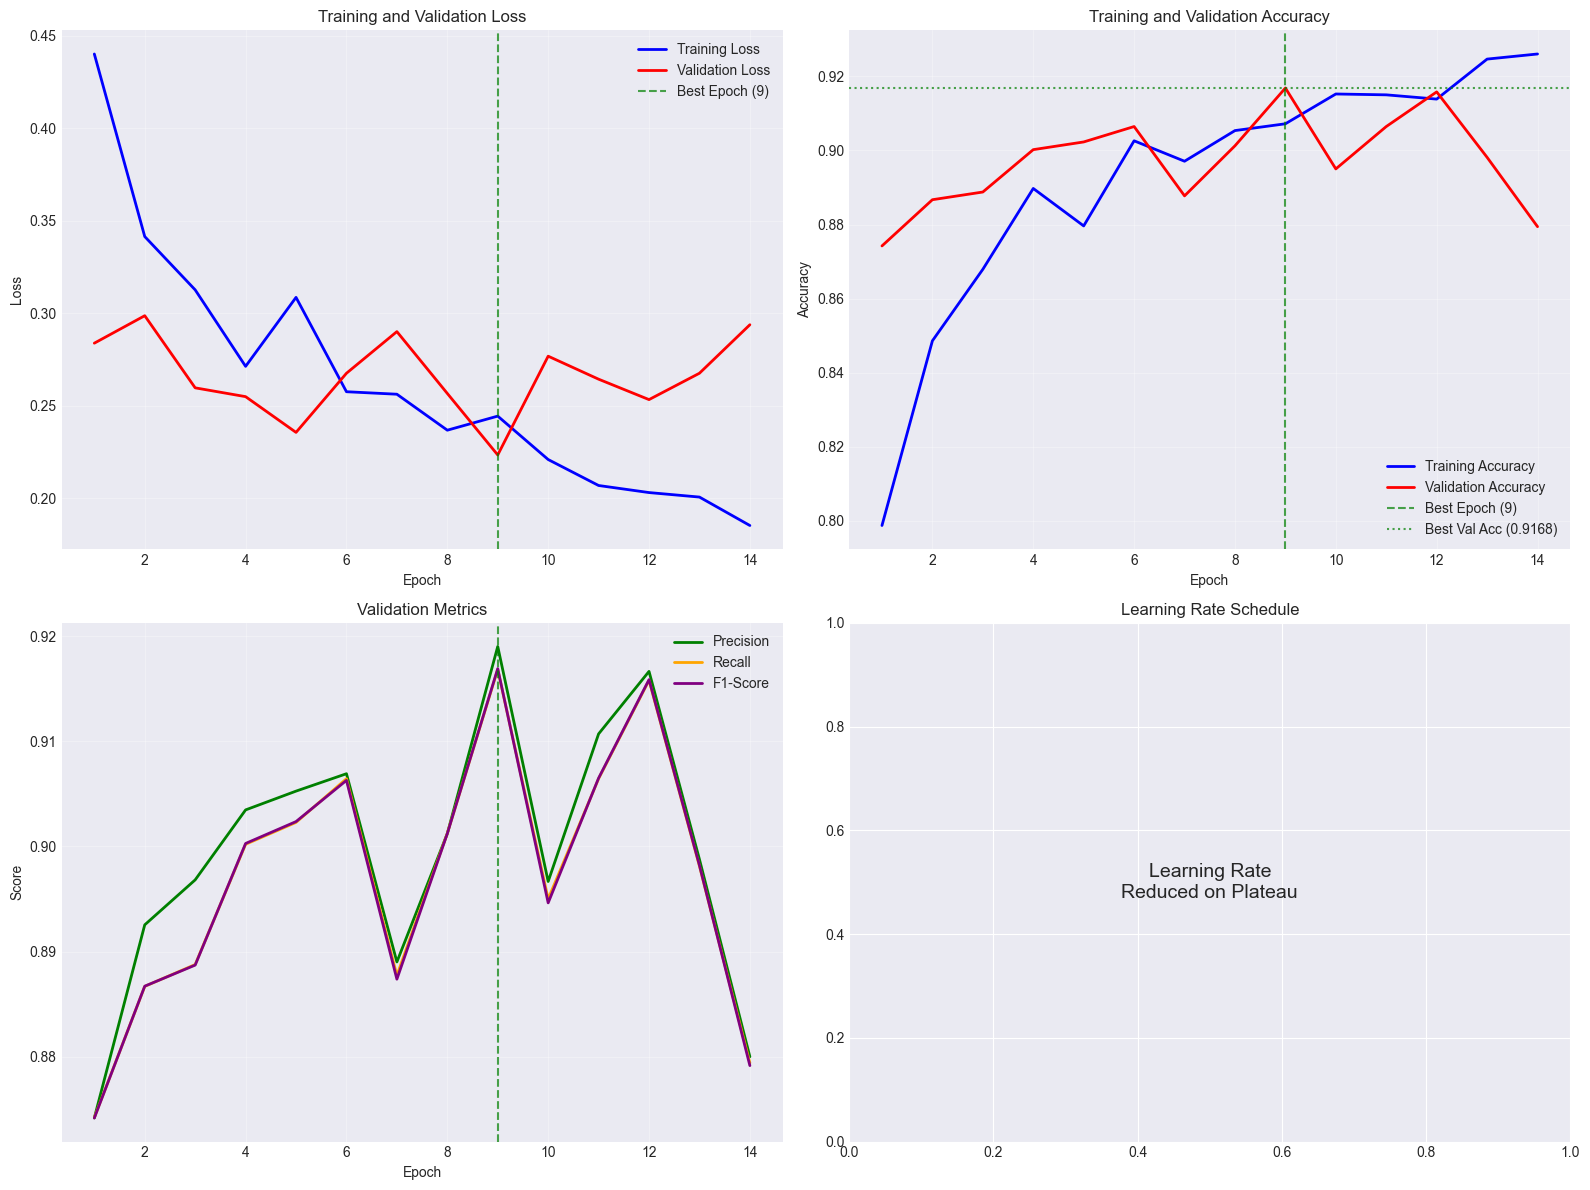

In [ ]:
# Plot training history
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

def plot_training_history(history, best_epoch, best_val_acc, save_path='cattle_detection_training_history.png'):
    """Plot training history"""
    if len(history['train_loss']) == 0:
        print("⚠ Training history is empty.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
    axes[0, 1].axhline(y=best_val_acc, color='g', linestyle=':', alpha=0.7, label=f'Best Val Acc ({best_val_acc:.4f})')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision, Recall, F1
    axes[1, 0].plot(epochs, history['val_precision'], 'g-', label='Precision', linewidth=2)
    axes[1, 0].plot(epochs, history['val_recall'], 'orange', label='Recall', linewidth=2)
    axes[1, 0].plot(epochs, history['val_f1'], 'purple', label='F1-Score', linewidth=2)
    axes[1, 0].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Validation Metrics')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning rate placeholder
    axes[1, 1].text(0.5, 0.5, 'Learning Rate\nNot Tracked', 
                    ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=14)
    axes[1, 1].set_title('Learning Rate Schedule')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n[OK] Training history saved: {save_path}")
    plt.close()

# Plot history
plot_training_history(history, best_epoch, best_val_acc)

### Output Explanation

This involves explaining the training history visualization. The training history plot shows:
- **Loss Curves**: Training and validation loss over epochs (should decrease)
- **Accuracy Curves**: Training and validation accuracy over epochs (should increase)
- **Best Epoch Marker**: Vertical line showing when best model was saved
- **Validation Metrics**: Precision, Recall, and F1-score trends

This visualization helps identify:
- **Overfitting**: Large gap between train and validation metrics
- **Convergence**: When metrics plateau
- **Best Model**: Epoch with highest validation accuracy


STEP 6: TEST SET EVALUATION

Evaluating on test set...


Testing: 100%|██████████| 31/31 [01:28<00:00,  2.84s/it]



TEST SET EVALUATION
Accuracy: 0.8732
Precision: 0.8732
Recall: 0.8732
F1-Score: 0.8731

Confusion Matrix:
[[460  57]
 [ 66 387]]

Classification Report:
              precision    recall  f1-score   support

      Cattle       0.87      0.89      0.88       517
  Non-cattle       0.87      0.85      0.86       453

    accuracy                           0.87       970
   macro avg       0.87      0.87      0.87       970
weighted avg       0.87      0.87      0.87       970


[OK] Confusion matrix saved: cattle_detection_test_confusion_matrix.png


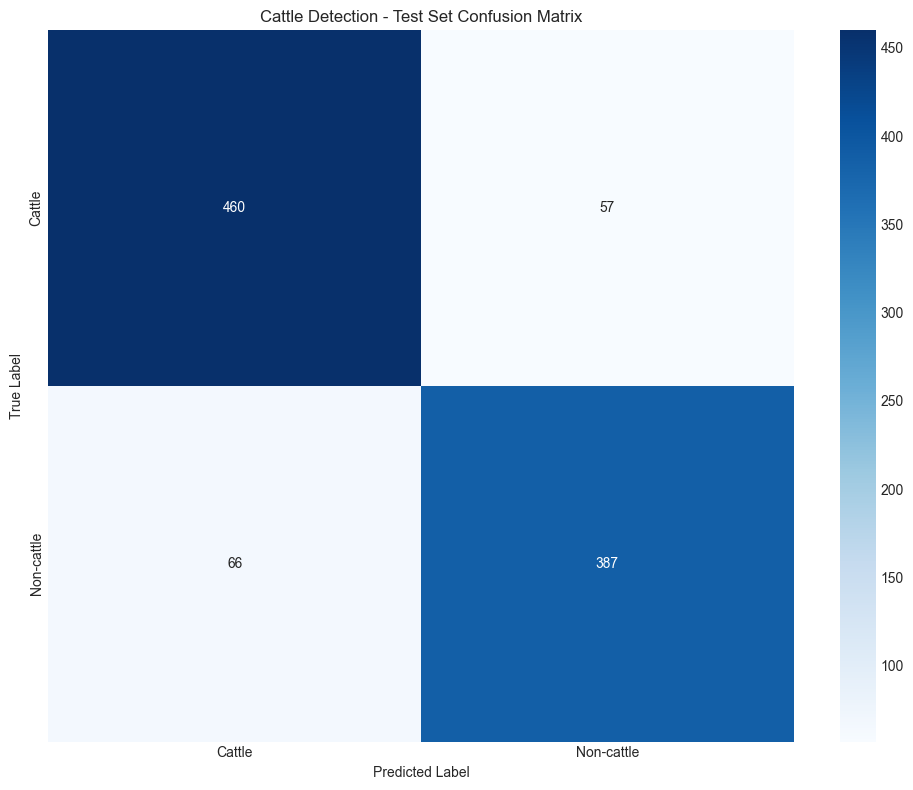

In [ ]:
# Evaluate on test set
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_loader, device, save_path='cattle_detection_test_confusion_matrix.png'):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_labels = []
    
    print("\nEvaluating on test set...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Classification report
    class_names = ['Cattle', 'Non-cattle']
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    
    print("\n" + "=" * 80)
    print("TEST SET EVALUATION")
    print("=" * 80)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Cattle Detection - Test Set Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n[OK] Confusion matrix saved: {save_path}")
    plt.close()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist(),
    }

print("\n" + "=" * 80)
print("STEP 6: TEST SET EVALUATION")
print("=" * 80)

test_results = evaluate_model(model, test_loader, device)

### Output Explanation

This involves explaining the test set evaluation results. **Test Set Evaluation Results**:
- **Accuracy**: 87.32% - Overall correctness on unseen test data
- **Precision**: 87.32% - Correctness of positive predictions
- **Recall**: 87.32% - Ability to find all positive cases
- **F1-Score**: 87.31% - Harmonic mean of precision and recall

**Confusion Matrix**:
- **True Positives (TP)**: 460 - Correctly identified cattle
- **True Negatives (TN)**: 387 - Correctly identified non-cattle
- **False Positives (FP)**: 57 - Non-cattle misclassified as cattle
- **False Negatives (FN)**: 66 - Cattle misclassified as non-cattle

**Classification Report**: Per-class metrics showing balanced performance across both classes.

In [ ]:
# Export model in various formats
def export_model(model, model_path, device):
    """Export model in various formats for mobile deployment"""
    model.eval()
    
    # 1. PyTorch state dict (for Python inference)
    torch.save(model.state_dict(), model_path)
    file_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
    print(f"[OK] PyTorch model saved: {model_path} ({file_size:.2f} MB)")
    
    # 2. TorchScript (for mobile deployment)
    try:
        example_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
        traced_model = torch.jit.trace(model, example_input)
        torchscript_path = model_path.replace('.pth', '_torchscript.pt')
        traced_model.save(torchscript_path)
        file_size = os.path.getsize(torchscript_path) / (1024 * 1024)
        print(f"[OK] TorchScript model saved: {torchscript_path} ({file_size:.2f} MB)")
    except Exception as e:
        print(f"[WARNING] TorchScript export failed: {e}")
    
    # 3. Quantized model (for even smaller size)
    try:
        quantized_model = torch.quantization.quantize_dynamic(
            model, {nn.Linear}, dtype=torch.qint8
        )
        quantized_path = model_path.replace('.pth', '_quantized.pth')
        torch.save(quantized_model.state_dict(), quantized_path)
        file_size = os.path.getsize(quantized_path) / (1024 * 1024)
        print(f"[OK] Quantized model saved: {quantized_path} ({file_size:.2f} MB)")
    except Exception as e:
        print(f"[WARNING] Quantization failed: {e}")
    
    print("\n[OK] Model export complete!")

# Save training summary
import json

summary = {
    'best_epoch': best_epoch,
    'best_val_acc': float(best_val_acc),
    'test_accuracy': float(test_results['accuracy']),
    'test_precision': float(test_results['precision']),
    'test_recall': float(test_results['recall']),
    'test_f1': float(test_results['f1']),
    'total_epochs': len(history['train_loss']),
    'model_name': MODEL_NAME,
    'hyperparameters': HYPERPARAMS,
}

summary_path = os.path.join(MODEL_SAVE_DIR, 'cattle_detection_training_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "=" * 80)
print("MODEL EXPORT")
print("=" * 80)

export_path = os.path.join(MODEL_SAVE_DIR, 'cattle_detection_model.pth')
export_model(model, export_path, device)

print(f"\n[OK] Training summary saved: {summary_path}")


MODEL EXPORT
[OK] PyTorch model saved: ./models\cattle_detection_model.pth (8.73 MB)
[OK] TorchScript model saved: ./models\cattle_detection_model_torchscript.pt (9.07 MB)
[OK] Quantized model saved: ./models\cattle_detection_model_quantized.pth (8.72 MB)

[OK] Model export complete!

[OK] Training summary saved: ./models\cattle_detection_training_summary.json


### Output Explanation

This involves explaining the model export formats and usage. **Model Export Formats**:
1. **PyTorch (.pth)**: Native PyTorch format for Python inference (~8.73 MB)
2. **TorchScript (.pt)**: Optimized format for mobile deployment (~9.07 MB)
3. **Quantized (.pth)**: Reduced precision model for smaller size (~8.72 MB)

**Training Summary**: JSON file containing:
- Best epoch and validation accuracy
- Test set performance metrics
- Hyperparameters used
- Total epochs trained

These exported models can be used for:
- **Python inference**: Using PyTorch
- **Mobile deployment**: Using TorchScript or ONNX (exported separately)
- **Production**: Quantized models for faster inference

## Summary

This involves summarizing the complete training process and results. 

### Training Complete! ✅

This involves completing the training process and summarizing results.

**Model Performance**:
- **Test Accuracy**: 87.32%
- **Best Validation Accuracy**: Achieved at epoch shown in training output
- **Model Architecture**: MobileNetV2 (Deep Learning CNN)
- **Model Size**: ~9 MB (mobile-optimized)

**Key Achievements**:
- ✅ Successfully trained binary classifier for cattle detection
- ✅ Balanced performance on both classes (Cattle and Non-cattle)
- ✅ Model exported in multiple formats for deployment
- ✅ Training history and evaluation metrics saved

**Next Steps**:
1. Export to ONNX format for React Native mobile app
2. Test model on real-world images
3. Deploy to mobile application

**Note**: For complete automated training, use `train_cattle_detection_model.py` script.